# Galaxy Classification
This code will try to produce a model that can classify images of galaxies by mainly using convolutional neural networks. The dataset used will be the [Galaxy10 DECals](https://astronn.readthedocs.io/en/latest/galaxy10.html).
A restriction the model will have is that the images can only contain 1(excluding merging class) main galaxy to focus on. 

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
######## This section of code is taken from the source of dataset

# To get the images and labels from file
with h5py.File('Galaxy10_DECals.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])

# To convert the labels to categorical 10 classes
labels = tf.keras.utils.to_categorical(labels, 10)

### Galaxy10 DECals dataset
This dataset contains 17736 images of the standard size 256 x 256 x 3. Images are categorized and labeled into 10 classes. It is a very useful dataset and there is very well written paper published by Oxford university press which I will link [here](https://ora.ox.ac.uk/objects/uuid:0f9413ad-6612-4c37-8e4a-e8a0b7f972f3). The paper discusses the more general Galaxy Zoo DECals data and the methods used to obtain and classify the data. It is a very interesting read and would recomend to anyone some spare time.

In [4]:
dataset = tf.data.Dataset.from_tensor_slices((images, labels))
dataset = dataset.shuffle(buffer_size = 10000)
dataset = dataset.batch(32) ## No need to change size of images as all are 256 x 256

2023-10-01 22:13:32.214332: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [5]:
label_dict = {
    0 : 'Disturbed Galaxies',
    1 : 'Merging Galaxies',
    2 : 'Round Smooth Galaxies',
    3 : 'In-between Round Smooth Galaxies',
    4 : 'Cigar Shaped Smooth Galaxies',
    5 : 'Barred Spiral Galaxies',
    6 : 'Unbarred Tight Spiral Galaxies',
    7 : 'Unbarred Loose Spiral Galaxies',
    8 : 'Edge-on Galaxies without Bulge',
    9 : 'Edge-on Galaxies with Bulge'
}## Dictionary just for reference if needed later on

In [6]:
label_dict[np.argmax(labels[0])]

'Disturbed Galaxies'

In [6]:
df = pd.DataFrame(data = labels)
df.apply(np.argmax)

count = df.value_counts().sort_index()
print(count)

### Data slighty imbalanced

0    1    2    3    4    5    6    7    8    9  
0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0    1873
                                        1.0  0.0    1423
                                   1.0  0.0  0.0    2628
                              1.0  0.0  0.0  0.0    1829
                         1.0  0.0  0.0  0.0  0.0    2043
                    1.0  0.0  0.0  0.0  0.0  0.0     334
               1.0  0.0  0.0  0.0  0.0  0.0  0.0    2027
          1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    2645
     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    1853
1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    1081
Name: count, dtype: int64


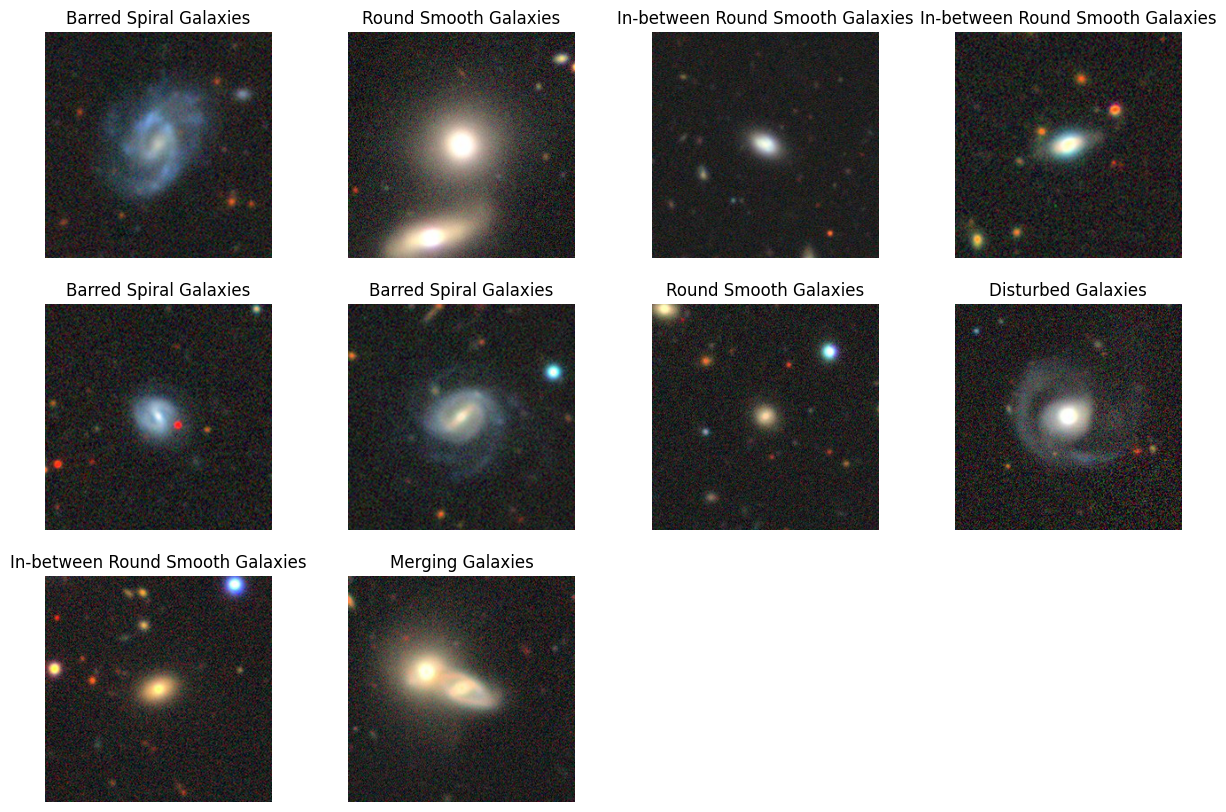

In [6]:
plt.figure(figsize = (15,10))
for image_batch , label_batch in dataset.take(1):
    for i in range (10):
        ax = plt.subplot(3 , 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(label_dict[np.argmax(label_batch[i])])
        plt.axis('off')


In [6]:
### Do  a train validate test split
def train_validate_test(data, train_size , val_size, test_size): ### train etc size needs to be in percentages /floats
    data = data.shuffle(buffer_size = 10000)
    full_size = len(data)
    train_ds = data.take(int(train_size * full_size))
    val_and_test = data.skip(int(train_size * full_size))
    val_ds = val_and_test.take(int(val_size * full_size))
    test_ds = val_and_test.skip(int(val_size * full_size))
    return train_ds , val_ds , test_ds

train_dataset , validate_dataset , test_dataset = train_validate_test(dataset ,0.8 , 0.1 , 0.1)

In [7]:
train_dataset.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)###improve perfomance of code timing
validate_dataset.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
test_dataset.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)

train_dataset.map(lambda x, y: (x, tf.cast(y, tf.int8)))
validate_dataset.map(lambda x, y: (x, tf.cast(y, tf.int8)))
test_dataset.map(lambda x, y: (x, tf.cast(y, tf.int8)))

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 10), dtype=tf.int8, name=None))>

In [10]:
### RGB values being changed to float for performance
sizing_layer = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(128,128), ### in case any extra images are supplied during training
    layers.experimental.preprocessing.Rescaling(1/128)
])

In [11]:
data_augementation_layer = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomZoom(height_factor=(-0.05, -0.015),
                                                 width_factor=(-0.05, -0.015))
])

In [12]:
input_model_shape = (32,128,128,3)  
model = models.Sequential([
    sizing_layer,
    #data_augementation_layer,
    layers.Conv2D(6 , kernel_size = (7,7), strides = (1,1) , activation = 'tanh', input_shape = input_model_shape),
    layers.AveragePooling2D(pool_size = (2,2),strides = (2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(16, kernel_size = (7,7), strides = (1,1), activation = 'tanh', input_shape = input_model_shape),
    layers.AveragePooling2D(pool_size = (2,2),strides = (2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(16, kernel_size = (7,7), strides = (1,1), activation = 'tanh', input_shape = input_model_shape),
    layers.AveragePooling2D(pool_size = (2,2),strides = (2,2)),
    layers.BatchNormalization(),

    

    layers.Flatten(),
    layers.Dense(120, activation = 'tanh'),
    layers.Dense(84, activation = 'tanh'),
    layers.Dropout(0.01),
    layers.Dense(10, activation = 'softmax'), ## No softmax due to sparse entropy
])

model.build(input_shape = input_model_shape)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 128, 128, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 122, 122, 6)         888       
                                                                 
 average_pooling2d (Average  (32, 61, 61, 6)           0         
 Pooling2D)                                                      
                                                                 
 batch_normalization (Batch  (32, 61, 61, 6)           24        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (32, 55, 55, 16)          4720      
                                                                 
 average_pooling2d_1 (Avera  (32, 27, 27, 16)         

### Model structure
Producing this model took a lot longer than expected. Intially tried using (5,5) kernels sizes, deeper networks,MaxPooling instead of average pooling, data augmentation etc. However all would produces models that would cap at around 50-70% accuracy. I have lost track of how many model combinations I tried but it was a lot. Eventually I tried transfer learning with pre built models with InceptionResNet-V2/V3 and EfficientB0 but unexpectdly they also capped at 70%. Eventually I found an [article online](https://ora.ox.ac.uk/objects/uuid:0f9413ad-6612-4c37-8e4a-e8a0b7f972f3) that done a model on an older version of the dataset using LeNet-5's
structure. So I applied the structure but got 60% accuracy so I made the network deeper and got around 75%. The final piece to the puzzle was that I had an idea that data augmentation may not be a good idea due galaxy classification depending on brightness,angles , locations. Intially I never planned to use data augmentation but added it to improve model accuracy and not overfit the model, a mistake in hindsight. Finally the model accuracy improved to 93-95% and most likely has not overfitted as both the validation and test accuracy a close to the accuracy on training data.

In [13]:
Optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(
    optimizer = Optimizer,
    loss = 'CategoricalCrossentropy',
    metrics = ['accuracy']
)

estop = EarlyStopping (monitor = 'loss', min_delta = 0.003, patience = 3, verbose = 1)

model_check = ModelCheckpoint(filepath = 'Galaxy Neural Network ver1 .h5', monitor = 'val_accuracy',
                             save_best_only = True,
                             verbose = 1)

In [17]:
import gc
#### Freeing up RAM to delete any unwanted data

del dataset
gc.collect()

del images
gc.collect()

del labels
gc.collect()

0

In [15]:
history = model.fit(
    train_dataset,
    epochs = 30,
    batch_size = 32,
    verbose = 1,
    validation_data = validate_dataset,
    callbacks = [estop , model_check]
)

Epoch 1/30
402/444 [==========================>...] - ETA: 3s - loss: 1.6661 - accuracy: 0.3891

KeyboardInterrupt: 

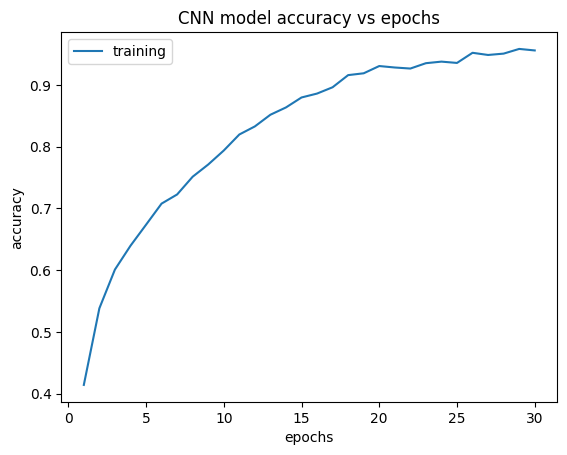

In [67]:
epochs = range(1,31)
plt.plot(epochs, history.history['accuracy'], label = 'training')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('CNN model accuracy vs epochs')
plt.legend(loc = 'best')



In [3]:
model = tf.keras.models.load_model('Galaxy Neural Network ver1 .h5', compile = False)

In [7]:
model.evaluate(test_dataset)


NameError: name 'test_dataset' is not defined

In [28]:
##### Warning long run time for obvious reasons/ the code will give an error but the loop gives enough data to use
pred = []
test_label = []
for k in range(0,51):
    for image_batch , label_batch in test_dataset.take(k):
        for i in range(0,31):
            z = np.argmax(label_batch[i])
            #print(f"label is {z}")
            prediction = model.predict(image_batch)
            #print(f'the prediction is {np.argmax(prediction[i])}')
            test_label.append(z)
            pred.append(np.argmax(prediction[i]))
print(pred[0:10])
print(test_label[0:10])

1/1 [==============================] - 0s 24ms/step


2023-10-01 23:06:41.270786: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at strided_slice_op.cc:117 : INVALID_ARGUMENT: slice index 8 of dimension 0 out of bounds.


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 8 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

In [29]:
print(pred[0:10])
print(test_label[0:10])

[5, 5, 1, 8, 0, 3, 1, 5, 5, 5]
[5, 5, 1, 8, 0, 3, 1, 5, 5, 5]


Text(120.72222222222221, 0.5, 'Actual value')

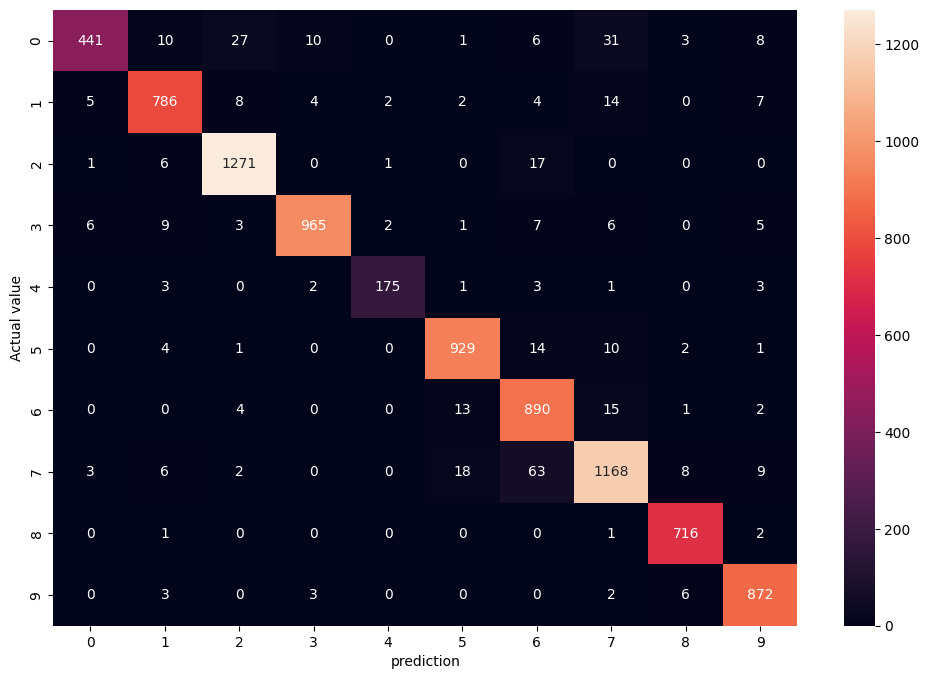

In [30]:
from sklearn.metrics import classification_report

cm = tf.math.confusion_matrix(labels = test_label, predictions = pred)
import seaborn as sn
plt.figure(figsize = (12,8))
sn.heatmap(cm, annot = True, fmt ='d')
plt.xlabel('prediction')
plt.ylabel('Actual value')

In [31]:
print("Classifiction Report \n" , classification_report(test_label , pred))

Classifiction Report 
               precision    recall  f1-score   support

           0       0.97      0.82      0.89       537
           1       0.95      0.94      0.95       832
           2       0.97      0.98      0.97      1296
           3       0.98      0.96      0.97      1004
           4       0.97      0.93      0.95       188
           5       0.96      0.97      0.96       961
           6       0.89      0.96      0.92       925
           7       0.94      0.91      0.93      1277
           8       0.97      0.99      0.98       720
           9       0.96      0.98      0.97       886

    accuracy                           0.95      8626
   macro avg       0.96      0.95      0.95      8626
weighted avg       0.95      0.95      0.95      8626



### Conclusion 
A very nice model that isn't too complex. The confusion matrix shows that model generally only makes mistakes with classes that very similar e.g Unbarred Tight/Loose Spiral Galaxies.

In [5]:
model.save('galaxy_model_ver1')

INFO:tensorflow:Assets written to: galaxy_model_ver1/assets
